In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import math
import scipy.stats

In [6]:
def GMM(N, pi, mu, Sigma):
    weight = [0]
    weight.extend(np.cumsum(pi))
    u = np.random.rand(N)
    L = np.zeros((N))
    x = np.zeros((N, 2))
    for i in range(len(pi)):
        indices = np.where(np.logical_and(u >= weight[i], u < weight[i+1]) == True)
        L[indices] = i * np.ones(len(indices))
        for k in indices[0]:
            x[k,:] = np.random.multivariate_normal(mu[i,:], Sigma[:,:,i])
    return x, L

In [3]:
def phi(Y, mu_k, Sigma_k):
    norm = scipy.stats.multivariate_normal(mean=mu_k, Sigma=Sigma_k)
    return norm.pdf(Y)

def getExpectation(Y, mu, Sigma, alpha):
    N = Y.shape[0]
    K = alpha.shape[0]
    gamma = np.mat(np.zeros((N, K)))
    prob = np.zeros((N, K))
    for k in range(K):
        prob[:, k] = phi(Y, mu[k], Sigma[k])
    prob = np.mat(prob)
    
    for k in range(K):
        gamma[:, k] = alpha[k] * prob[:, k]
    for i in range(N):
        gamma[i, :] /= np.sum(gamma[i, :])
    return gamma

def maximize(Y, gamma):
    N, D = Y.shape
    K = gamma.shape[1]
    mu = np.zeros((K, D))
    Sigma = []
    alpha = np.zeros(K)

    for k in range(K):
        Nk = np.sum(gamma[:, k])
        mu[k, :] = np.sum(np.multiply(Y, gamma[:, k]), axis=0) / Nk
        Sigma_k = (Y - mu[k]).T * np.multiply((Y - mu[k]), gamma[:, k]) / Nk
        Sigma.append(Sigma_k)
        alpha[k] = Nk / N
    Sigma = np.array(Sigma)
    return mu, Sigma, alpha

def scale_data(Y):
    for i in range(Y.shape[1]):
        max_ = Y[:, i].max()
        min_ = Y[:, i].min()
        Y[:, i] = (Y[:, i] - min_) / (max_ - min_)
    return Y

def init_params(shape, K):
n, D = shape
mu = np.random.rand(K, D)
Sigma = np.array([np.eye(D)] * K)
alpha = np.array([1.0 / K] * K)
return mu, Sigma, alpha

def EM(Y, K):
    Y = scale_data(Y)
    mu, Sigma, alpha = init_params(Y.shape, K)
    gamma = getExpectation(Y, mu, Sigma, alpha)
    mu, Sigma, alpha = maximize(Y, gamma)
    return alpha, mu, Sigma

In [4]:
def logLH(X, alpha, mu, Sigma):
    n_sample = len(X)
    M = len(alpha)
    pdfx = np.zeros([n_sample,M])
    for i in range(M):
        pdfx[:,i] = alpha[i] * scipy.stats.multivariate_normal.pdf(X, mu[i], Sigma[:,:,i])
    LLH = sum(np.log(pdfx.sum(axis=1)) + 1e-5)#precision？
    return LLH

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  # This is added back by InteractiveShellApp.init_path()
G:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


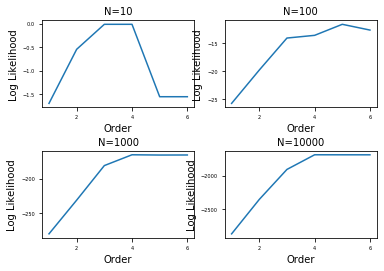

In [9]:
mu_true = np.array([[1,1],[-1,1],[-1,-1],[1,-1]])
Sigma_true = np.zeros([2,2,4])
Sigma_true[:,:,0] = 0.1*np.array([[-0.5,1],
                                    [1,-0.5]])
Sigma_true[:,:,1] = 0.1*np.array([[0.5,1],
                                    [1,0.5]])
Sigma_true[:,:,2] = 0.1*np.array([[1,-0.5],
                                    [-0.5,1]])
Sigma_true[:,:,3] = 0.1*np.array([[1,0.5],
                                    [0.5,1]])
alpha_true = np.array([0.15,0.20,0.30,0.35])
K = 10                           
M_max = 6
counter = 1
    
    
for N in [10,100,1000,10000]:
    X, L = GMM(N, alpha_true, mu_true, Sigma_true)
    part = np.ceil(np.linspace(0,N,K+1))
    index_partition_limit = np.zeros([K,2])
    for k in range(K):
        index_partition_limit[k,:] = [part[k],part[k+1]-1]
    M = np.linspace(1,M_max,M_max)
    logLH_est = np.zeros(M_max)
    for i in range(M_max):
        logLH_valid = np.zeros(K)
        for k in range(K):
            ind_valid = np.arange(index_partition_limit[k,0], index_partition_limit[k,1]+1)
            ind_valid = ind_valid.astype(int)
            X_valid = X[ind_valid,:]
            ind_train = np.hstack((np.arange(0,index_partition_limit[k,0]),np.arange(index_partition_limit[k,1]+1, N)))
            ind_train = ind_train.astype(int)
            X_train = X[ind_train,:]
            alpha, mu, Sigma = EM(X_train, i+1)
            logLH_valid[k] = logLH(X_valid, alpha, mu, Sigma)
        logLH_est[i] = np.max(logLH_valid)
    plt.subplot(2,2,counter)
    plt.plot(M,logLH_est, label='N=%d'%N)
    plt.xlabel('Order', fontsize=10)
    plt.ylabel('Log Likelihood', fontsize=10)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.title('N=%d'%N, fontsize =10)
    plt.subplots_adjust(hspace=0.5)
    counter += 1
plt.show()